In [17]:
import os
import cv2
import math
import numpy as np
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from tqdm import tqdm
from PIL import Image
import matplotlib.pylab as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Importazione dei dati

### Definisco le directory

In [18]:
images = "Data/cat_dog/"
labels = "Data/cat_dog.csv"

### Estraggo le immagini e i nomi dei file per cerare il dataset

In [19]:
img_path = [images+img for img in os.listdir(images)]

print(img_path[:5])
print(len(img_path))

['Data/cat_dog/cat.0.jpg', 'Data/cat_dog/cat.1.jpg', 'Data/cat_dog/cat.10.jpg', 'Data/cat_dog/cat.100.jpg', 'Data/cat_dog/cat.1000.jpg']
25000


#### Essendo che la label ("cat"/"dog") è già presente nel nome dell'immagine posso tralasciare l'utilizzo del csv
Mi assicuro quindi che i nomi delle immagini siano coerenti

In [20]:
with open(labels, 'r') as f:
    for line in f:
        if (line[:3] == 'dog' and line[-2] != '1') or (line[:3] == 'cat' and line[-2] != '0'):
            raise Exception

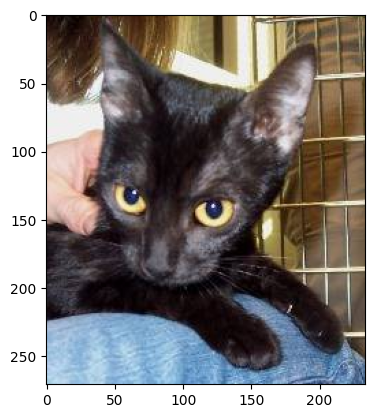

In [21]:
import random

with Image.open(img_path[random.randint(0, 24999)]) as img:
    plt.imshow(img)

# Definisco la classe Dataset

In [22]:
class CatDogDataset(Dataset):
    def __init__(self, images_path, device='cuda' if torch.cuda.is_available() else 'cpu', image_size=(512, 512), augmentation=True):
        self.images = images_path
        self.device = device
        self.img_size = image_size
        self.augmentation = augmentation

        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        if self.augmentation:
            self.image_augmentation = transforms.Compose([
                transforms.RandomRotation(90),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAdjustSharpness(2)
            ])

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = 1 if os.path.basename(image_path).startswith('dog') else 0

        if self.augmentation:
            image = self.image_augmentation(image)

        image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.images)

In [23]:
train, test = train_test_split(img_path, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f'Train size: {len(train)}, Eval size: {len(val)}, Test size: {len(test)}')

Train size: 18000, Eval size: 4500, Test size: 2500


In [24]:
train_dataset = CatDogDataset(train, augmentation=True)
val_dataset = CatDogDataset(val, augmentation=True)
test_dataset = CatDogDataset(test, augmentation=False)

In [25]:
toPIL = transforms.ToPILImage()
batch_size = 32

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

# Creazione del Modello

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Struttura del modello
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)      # 512x512 -> 256x256
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)     # 256x256 -> 128x128
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)    # 128x128 -> 64x64
        self.conv4 = nn.Conv2d(128, 256, 3, 1, padding=1)   # 64x64 -> 32x32
        self.conv5 = nn.Conv2d(256, 512, 3, 1, padding=1)   # 32x32 -> 16x16
        self.pooling = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512 * 16 * 16, 256)
        self.dense2 = nn.Linear(256, 64)
        self.dense3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = self.pooling(F.relu(self.conv1(x)))
        x = self.pooling(F.relu(self.conv2(x)))
        x = self.pooling(F.relu(self.conv3(x)))
        x = self.pooling(F.relu(self.conv4(x)))
        x = self.pooling(F.relu(self.conv5(x)))
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.relu(self.dense3(x))
        x = torch.sigmoid(self.output(x))

        return x

model = CNN().to(device)

In [27]:
n_epoch = 50

criterion = nn.BCELoss()
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)   # Decremento del learning rate ogni 10 epoche

train_loss_plot = []
train_accuracy_plot = []
train_f1_plot = []
val_loss_plot = []
val_accuracy_plot = []
val_f1_plot = []

for epoch in range(n_epoch):
    print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    model.train()
    for i, data in enumerate(train_dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        # Volendo si può usare anche la funzione torch.round(outputs) per arrotondare i valori ma è più rigoroso usare la riga sopra
        # predicted = torch.round(outputs)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    scheduler.step()
    f1 = f1_score(all_labels, all_predictions, average='binary')
    accuracy = accuracy_score(all_labels, all_predictions)
    train_loss_plot.append(running_loss / len(train_dataloader))
    train_accuracy_plot.append(accuracy)
    train_f1_plot.append(f1)
    print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / (i + 1):.3f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.2f}')

    model.eval()
    val_loss = 0.0
    val_all_labels = []
    val_all_predictions = []

    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device).float()

            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            val_all_labels.extend(labels.cpu().numpy())
            val_all_predictions.extend(predicted.cpu().numpy())

    val_f1 = f1_score(val_all_labels, val_all_predictions, average='binary')
    val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
    val_accuracy_plot.append(val_accuracy)
    val_f1_plot.append(val_f1)
    val_loss_plot.append(val_loss / len(val_dataloader))
    print(f'Validation loss: {val_loss / len(val_dataloader):.3f}, Validation Accuracy: {val_accuracy:.2f}, Validation F1 Score: {val_f1:.2f}')

print("Fine Addestramento")

[Epoch 1, Batch 563] loss: 0.666, Accuracy: 0.57%, F1 Score: 0.62
Learning rate: 0.001000
Validation loss: 0.634, Validation Accuracy: 0.63%, Validation F1 Score: 0.58
[Epoch 2, Batch 563] loss: 0.612, Accuracy: 0.65%, F1 Score: 0.64
Learning rate: 0.001000
Validation loss: 0.628, Validation Accuracy: 0.68%, Validation F1 Score: 0.65
[Epoch 3, Batch 563] loss: 0.580, Accuracy: 0.69%, F1 Score: 0.69
Learning rate: 0.001000
Validation loss: 0.573, Validation Accuracy: 0.70%, Validation F1 Score: 0.68
[Epoch 4, Batch 563] loss: 0.554, Accuracy: 0.71%, F1 Score: 0.71
Learning rate: 0.001000
Validation loss: 0.535, Validation Accuracy: 0.72%, Validation F1 Score: 0.71
[Epoch 5, Batch 563] loss: 0.528, Accuracy: 0.74%, F1 Score: 0.73
Learning rate: 0.001000
Validation loss: 0.511, Validation Accuracy: 0.76%, Validation F1 Score: 0.77
[Epoch 6, Batch 563] loss: 0.509, Accuracy: 0.75%, F1 Score: 0.74
Learning rate: 0.001000
Validation loss: 0.509, Validation Accuracy: 0.75%, Validation F1 Scor

# Mostro i grafici di addestramento, matrici di correlazione dell'f1Score

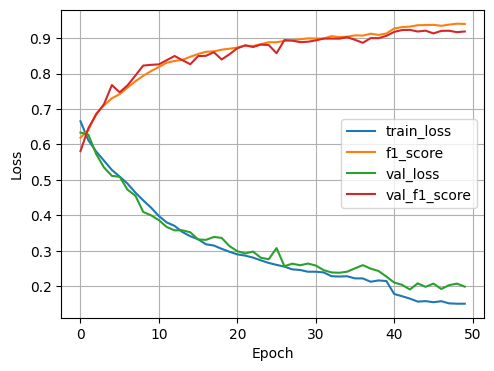

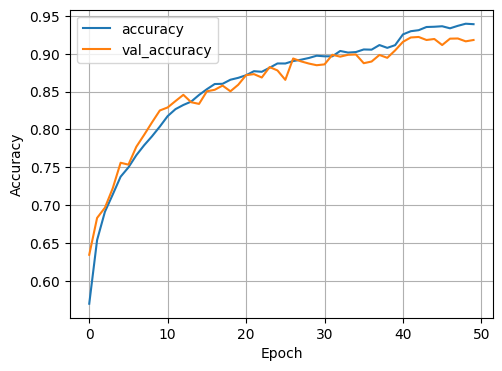

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_plot, label='train_loss')
plt.plot(train_f1_plot, label='f1_score')
plt.plot(val_loss_plot, label='val_loss')
plt.plot(val_f1_plot, label='val_f1_score')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_plot, label='accuracy')
plt.plot(val_accuracy_plot, label='val_accuracy')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Test del modello

In [36]:
model.eval()
test_loss = 0.0
test_all_labels = []
test_all_predictions = []
test_loss_plot = []
test_accuracy_plot = []
test_f1_plot = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device).float()

        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        test_all_labels.extend(labels.cpu().numpy())
        test_all_predictions.extend(predicted.cpu().numpy())

f1 = f1_score(test_all_labels, test_all_predictions, average='binary')
accuracy = accuracy_score(test_all_labels, test_all_predictions)
print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')

Accuracy: 0.92, F1 Score: 0.92
